# IT Academy - Data Science amb Python
## Tasca 7: Estructura de control

###  [Github Registre de Logs](https://github.com/jesussantana/Registre_de_logs)

###  Exercici 1
- Normalitza, identifica i enumera cada un dels atributs / variables de l'estructura de l'arxiu "Web_access_log-akumenius.com" que trobaràs al repositori de GitHub "Data-sources".

In [1]:
import numpy as np
import pandas as pd
import time
import requests
import re
from datetime import datetime
from datetime import timedelta

pd.set_option('display.max_columns', None)

In [2]:
path = '../Data/Web_access_log-akumenius.com.txt'

Logs_raw = pd.read_csv(path, sep='\s | \- | \"', names =['DNS','IP','Location','Date','Time','Request','Status','Size','Referer','UserAgent'], nrows = 5000, engine='python')

Logs_copy = Logs_raw.copy()

Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN
1,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN
2,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN
3,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN
4,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN


###  Exercici 2
- Neteja, preprocesa, estructura i transforma (dataframe) les dades del registre d'Accés a la web.

In [3]:
Logs_copy.tail()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
4995,www.akumenius.com 162.243.192.191,- [23/Feb/2014:05:51:04 +0100],"GET /escapadas/galicia-724.html HTTP/1.1"" 200 ...","http://www.akumenius.com/escapadas""",Mozilla/5.0 (compatible; spbot/4.0.7; +http://...,NaN,NaN,NaN,NaN,NaN
4996,www.akumenius.com 66.249.76.216,- [23/Feb/2014:05:51:00 +0100],GET /destinos-caracteristicas/hoteles-baratos-...,"-""",Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,NaN,NaN,NaN,NaN,NaN
4997,www.akumenius.com 180.76.6.58,- [23/Feb/2014:05:51:02 +0100],GET /destinos-baratos/destinos-caracteristicas...,"-""",Mozilla/5.0 (compatible; Baiduspider/2.0; +htt...,NaN,NaN,NaN,NaN,NaN
4998,www.akumenius.com 162.243.192.191,- [23/Feb/2014:05:51:08 +0100],"GET /escapadas/navarra-516.html HTTP/1.1"" 200 ...","http://www.akumenius.com/escapadas""",Mozilla/5.0 (compatible; spbot/4.0.7; +http://...,NaN,NaN,NaN,NaN,NaN
4999,www.akumenius.com 157.56.93.71,- [23/Feb/2014:05:51:08 +0100],GET /escapadas/escapada-gourmet-experience-del...,"-""",Mozilla/5.0 (compatible; bingbot/2.0; +http://...,NaN,NaN,NaN,NaN,NaN


In [4]:
Logs_copy.shape

(5000, 10)

In [5]:
Logs_copy.isnull().sum()

DNS             0
IP              0
Location        0
Date            0
Time            0
Request      5000
Status       5000
Size         5000
Referer      5000
UserAgent    5000
dtype: int64

In [6]:
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN
1,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN
2,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN
3,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN
4,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN


In [7]:
Logs_copy.tail()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
4995,www.akumenius.com 162.243.192.191,- [23/Feb/2014:05:51:04 +0100],"GET /escapadas/galicia-724.html HTTP/1.1"" 200 ...","http://www.akumenius.com/escapadas""",Mozilla/5.0 (compatible; spbot/4.0.7; +http://...,NaN,NaN,NaN,NaN,NaN
4996,www.akumenius.com 66.249.76.216,- [23/Feb/2014:05:51:00 +0100],GET /destinos-caracteristicas/hoteles-baratos-...,"-""",Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,NaN,NaN,NaN,NaN,NaN
4997,www.akumenius.com 180.76.6.58,- [23/Feb/2014:05:51:02 +0100],GET /destinos-baratos/destinos-caracteristicas...,"-""",Mozilla/5.0 (compatible; Baiduspider/2.0; +htt...,NaN,NaN,NaN,NaN,NaN
4998,www.akumenius.com 162.243.192.191,- [23/Feb/2014:05:51:08 +0100],"GET /escapadas/navarra-516.html HTTP/1.1"" 200 ...","http://www.akumenius.com/escapadas""",Mozilla/5.0 (compatible; spbot/4.0.7; +http://...,NaN,NaN,NaN,NaN,NaN
4999,www.akumenius.com 157.56.93.71,- [23/Feb/2014:05:51:08 +0100],GET /escapadas/escapada-gourmet-experience-del...,"-""",Mozilla/5.0 (compatible; bingbot/2.0; +http://...,NaN,NaN,NaN,NaN,NaN


In [8]:
# Reorder columns of data

Logs_copy.UserAgent = Logs_copy.Time
Logs_copy.Request = Logs_copy.Location
Logs_copy.Referer = Logs_copy.Date
Logs_copy.Date = Logs_copy.IP
Logs_copy.Time = Logs_copy.IP = np.nan
Logs_copy.Location = ""


Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost 127.0.0.1,NaN,,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost 127.0.0.1,NaN,,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost 127.0.0.1,NaN,,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost 127.0.0.1,NaN,,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost 127.0.0.1,NaN,,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"


In [9]:
# DNS & IP data split

Logs_copy[['DNS','IP']] = Logs_copy.DNS.str.split('\s', expand = True).get([0, 1])

In [10]:
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"


In [11]:
Logs_copy.DNS.unique()

array(['localhost', 'www.akumenius.com', 'akumenius.com'], dtype=object)

In [12]:
# Time data extraction

Logs_copy.Time = Logs_copy.Date.str.extract(':(\d{2}:\d{2}:\d{2}.*)]')

#Logs_copy.Time = pd.to_datetime(Logs_copy.Time, format = '%H:%M:%S %z')
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,,- [23/Feb/2014:03:10:31 +0100],03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,,- [23/Feb/2014:03:10:31 +0100],03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,,- [23/Feb/2014:03:10:31 +0100],03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,,- [23/Feb/2014:03:10:31 +0100],03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,,- [23/Feb/2014:03:10:31 +0100],03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"


In [13]:
# Date data extraction

Logs_copy.Date = Logs_copy.Date.str.extract('(\d+/\w+/\d+)')

#Logs_copy.Date = pd.to_datetime(Logs_copy.Date, format = '%d/%b/%Y')

In [14]:
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"


In [15]:
# Request & Status data split

Logs_copy[['Request','Status']] = Logs_copy.Request.str.split('\"', expand = True).get([0, 1])

In [16]:
Logs_copy.tail()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
4995,www.akumenius.com,162.243.192.191,,23/Feb/2014,05:51:04 +0100,GET /escapadas/galicia-724.html HTTP/1.1,200 13343,NaN,"http://www.akumenius.com/escapadas""",Mozilla/5.0 (compatible; spbot/4.0.7; +http://...
4996,www.akumenius.com,66.249.76.216,,23/Feb/2014,05:51:00 +0100,GET /destinos-caracteristicas/hoteles-baratos-...,200 8092,NaN,"-""",Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
4997,www.akumenius.com,180.76.6.58,,23/Feb/2014,05:51:02 +0100,GET /destinos-baratos/destinos-caracteristicas...,200 7159,NaN,"-""",Mozilla/5.0 (compatible; Baiduspider/2.0; +htt...
4998,www.akumenius.com,162.243.192.191,,23/Feb/2014,05:51:08 +0100,GET /escapadas/navarra-516.html HTTP/1.1,200 13753,NaN,"http://www.akumenius.com/escapadas""",Mozilla/5.0 (compatible; spbot/4.0.7; +http://...
4999,www.akumenius.com,157.56.93.71,,23/Feb/2014,05:51:08 +0100,GET /escapadas/escapada-gourmet-experience-del...,200 3100,NaN,"-""",Mozilla/5.0 (compatible; bingbot/2.0; +http://...


In [17]:
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"


In [18]:
# Size data extraction

Logs_copy.Size = Logs_copy.Status.str.extract('(\d+$)')
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"


In [19]:
# Clean Size data

sizes = []

for index, row in Logs_copy.iterrows(): 
    
    if re.search('200', row.Size):
        sizes.append(np.nan)
    else:
        sizes.append(row.Size)

Logs_copy.Size = sizes

Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"


In [20]:
# Status data extraction

Logs_copy.Status = Logs_copy.Status.str.extract('(\d{3})')
Logs_copy.tail()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
4995,www.akumenius.com,162.243.192.191,,23/Feb/2014,05:51:04 +0100,GET /escapadas/galicia-724.html HTTP/1.1,200,13343,"http://www.akumenius.com/escapadas""",Mozilla/5.0 (compatible; spbot/4.0.7; +http://...
4996,www.akumenius.com,66.249.76.216,,23/Feb/2014,05:51:00 +0100,GET /destinos-caracteristicas/hoteles-baratos-...,200,8092,"-""",Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
4997,www.akumenius.com,180.76.6.58,,23/Feb/2014,05:51:02 +0100,GET /destinos-baratos/destinos-caracteristicas...,200,7159,"-""",Mozilla/5.0 (compatible; Baiduspider/2.0; +htt...
4998,www.akumenius.com,162.243.192.191,,23/Feb/2014,05:51:08 +0100,GET /escapadas/navarra-516.html HTTP/1.1,200,13753,"http://www.akumenius.com/escapadas""",Mozilla/5.0 (compatible; spbot/4.0.7; +http://...
4999,www.akumenius.com,157.56.93.71,,23/Feb/2014,05:51:08 +0100,GET /escapadas/escapada-gourmet-experience-del...,200,3100,"-""",Mozilla/5.0 (compatible; bingbot/2.0; +http://...


In [21]:
# Clean Referer data

referers = []

for index, row in Logs_copy.iterrows(): 
    
    if re.search('-"', row.Referer):
        referers.append(np.nan)
    else:
        referers.append(row.Referer.rstrip(row.Referer[-1]))

Logs_copy.Referer = referers

In [22]:
Logs_copy

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
...,...,...,...,...,...,...,...,...,...,...
4995,www.akumenius.com,162.243.192.191,,23/Feb/2014,05:51:04 +0100,GET /escapadas/galicia-724.html HTTP/1.1,200,13343,http://www.akumenius.com/escapadas,Mozilla/5.0 (compatible; spbot/4.0.7; +http://...
4996,www.akumenius.com,66.249.76.216,,23/Feb/2014,05:51:00 +0100,GET /destinos-caracteristicas/hoteles-baratos-...,200,8092,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
4997,www.akumenius.com,180.76.6.58,,23/Feb/2014,05:51:02 +0100,GET /destinos-baratos/destinos-caracteristicas...,200,7159,NaN,Mozilla/5.0 (compatible; Baiduspider/2.0; +htt...
4998,www.akumenius.com,162.243.192.191,,23/Feb/2014,05:51:08 +0100,GET /escapadas/navarra-516.html HTTP/1.1,200,13753,http://www.akumenius.com/escapadas,Mozilla/5.0 (compatible; spbot/4.0.7; +http://...


###  Exercici 3
- Geolocalitza les IP's. Aqui tens una pagina de interes:
  - [IP2Locattion](https://blog.ip2location.com/knowledge-base/how-to-add-a-sub-account-in-ip2location/)

In [23]:
import json
from ip2geotools.databases.noncommercial import DbIpCity

In [24]:
# Extract Ips

ips = Logs_copy.IP.unique()

In [25]:
# Function for extract Locations

localhost = "127.0.0.1"

def extract_location(ip):
    
    try:
        if ip == localhost:
            return ('Local', 'Local')

        else:
            response = DbIpCity.get(ip, api_key = 'free').to_json()    
            data = json.loads(response)
            return data['city'], data['country']
    
    except:
        return np.nan

In [26]:
# Extract Location Test

extract_location(Logs_copy.IP[50])

nan

In [27]:
# List of locations for unique Ips
start = time.monotonic()

locations = []

for item in ips:
    
    locations.append(extract_location(item))  

end = time.monotonic()

print(timedelta(seconds = end - start))

0:01:42.076208


In [28]:
# Compare ips & add location
start = time.monotonic()

IP_locations = []

for index, row in Logs_copy.iterrows():
    
    # iterate the two lists
    for a, b in zip(ips, locations):
        
        # Compare & add
        if row.IP == a:
            IP_locations.append(b)  

end = time.monotonic()

print(timedelta(seconds = end - start))

0:00:07.539734


In [29]:
Logs_copy.Location = IP_locations

In [30]:
Logs_copy

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
...,...,...,...,...,...,...,...,...,...,...
4995,www.akumenius.com,162.243.192.191,"(New York, US)",23/Feb/2014,05:51:04 +0100,GET /escapadas/galicia-724.html HTTP/1.1,200,13343,http://www.akumenius.com/escapadas,Mozilla/5.0 (compatible; spbot/4.0.7; +http://...
4996,www.akumenius.com,66.249.76.216,NaN,23/Feb/2014,05:51:00 +0100,GET /destinos-caracteristicas/hoteles-baratos-...,200,8092,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
4997,www.akumenius.com,180.76.6.58,"(Beijing, CN)",23/Feb/2014,05:51:02 +0100,GET /destinos-baratos/destinos-caracteristicas...,200,7159,NaN,Mozilla/5.0 (compatible; Baiduspider/2.0; +htt...
4998,www.akumenius.com,162.243.192.191,"(New York, US)",23/Feb/2014,05:51:08 +0100,GET /escapadas/navarra-516.html HTTP/1.1,200,13753,http://www.akumenius.com/escapadas,Mozilla/5.0 (compatible; spbot/4.0.7; +http://...


###  Exercici 4
- Mostreu-me la teva creativitat, Sorprèn-me fes un pas més enllà amb el analysis anterior.

In [31]:
# Extract UserAgent Data

from device_detector import SoftwareDetector

Devices = Logs_copy.UserAgent
device = []

for x in Devices:
    
    device.append(SoftwareDetector(x).parse())

client_name = []
client_type = []
client_version = []
os_name = []
os_version = []
device_type = []

for x in device:
    
    client_name.append(x.client_name())
    client_type.append(x.client_type())
    client_version.append(x.client_version())
    os_name.append(x.os_name())
    os_version.append(x.os_version())
    device_type.append(x.device_type())

Logs_copy['Client_Name'] = client_name
Logs_copy['Client_Type'] = client_type
Logs_copy['Client_Version'] = client_version
Logs_copy['Os_Name'] = os_name
Logs_copy['Os_Version'] = os_version
Logs_copy['Device_Type'] = device_type

Logs_copy

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent,Client_Name,Client_Type,Client_Version,Os_Name,Os_Version,Device_Type
0,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-","Apache (internal dummy connection)"" VLOG=-",generic,None,,,
1,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-","Apache (internal dummy connection)"" VLOG=-",generic,None,,,
2,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-","Apache (internal dummy connection)"" VLOG=-",generic,None,,,
3,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-","Apache (internal dummy connection)"" VLOG=-",generic,None,,,
4,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-","Apache (internal dummy connection)"" VLOG=-",generic,None,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,www.akumenius.com,162.243.192.191,"(New York, US)",23/Feb/2014,05:51:04 +0100,GET /escapadas/galicia-724.html HTTP/1.1,200,13343,http://www.akumenius.com/escapadas,Mozilla/5.0 (compatible; spbot/4.0.7; +http://...,spbot,generic,4.0.7,,,
4996,www.akumenius.com,66.249.76.216,NaN,23/Feb/2014,05:51:00 +0100,GET /destinos-caracteristicas/hoteles-baratos-...,200,8092,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,Googlebot,generic,2.1,,,
4997,www.akumenius.com,180.76.6.58,"(Beijing, CN)",23/Feb/2014,05:51:02 +0100,GET /destinos-baratos/destinos-caracteristicas...,200,7159,NaN,Mozilla/5.0 (compatible; Baiduspider/2.0; +htt...,Baiduspider,generic,2.0,,,
4998,www.akumenius.com,162.243.192.191,"(New York, US)",23/Feb/2014,05:51:08 +0100,GET /escapadas/navarra-516.html HTTP/1.1,200,13753,http://www.akumenius.com/escapadas,Mozilla/5.0 (compatible; spbot/4.0.7; +http://...,spbot,generic,4.0.7,,,


In [32]:
Logs_copy.UserAgent[0]

'Apache (internal dummy connection)" VLOG=-'

In [33]:
del(Logs_copy['UserAgent'])

Logs_copy.tail()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,Client_Name,Client_Type,Client_Version,Os_Name,Os_Version,Device_Type
4995,www.akumenius.com,162.243.192.191,"(New York, US)",23/Feb/2014,05:51:04 +0100,GET /escapadas/galicia-724.html HTTP/1.1,200,13343,http://www.akumenius.com/escapadas,spbot,generic,4.0.7,,,
4996,www.akumenius.com,66.249.76.216,NaN,23/Feb/2014,05:51:00 +0100,GET /destinos-caracteristicas/hoteles-baratos-...,200,8092,NaN,Googlebot,generic,2.1,,,
4997,www.akumenius.com,180.76.6.58,"(Beijing, CN)",23/Feb/2014,05:51:02 +0100,GET /destinos-baratos/destinos-caracteristicas...,200,7159,NaN,Baiduspider,generic,2.0,,,
4998,www.akumenius.com,162.243.192.191,"(New York, US)",23/Feb/2014,05:51:08 +0100,GET /escapadas/navarra-516.html HTTP/1.1,200,13753,http://www.akumenius.com/escapadas,spbot,generic,4.0.7,,,
4999,www.akumenius.com,157.56.93.71,"(Newark, US)",23/Feb/2014,05:51:08 +0100,GET /escapadas/escapada-gourmet-experience-del...,200,3100,NaN,bingbot,generic,2.0,,,


In [34]:
# Clean Client Data
client = []

for index, row in Logs_copy.iterrows(): 
    
    if re.search('Apache', row.Client_Name):
        client.append(row.Client_Name[0:6])
    else:
        client.append(row.Client_Name)

Logs_copy.Client_Name = client

Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,Client_Name,Client_Type,Client_Version,Os_Name,Os_Version,Device_Type
0,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache,generic,None,,,
1,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache,generic,None,,,
2,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache,generic,None,,,
3,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache,generic,None,,,
4,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache,generic,None,,,


In [35]:
Logs_copy

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,Client_Name,Client_Type,Client_Version,Os_Name,Os_Version,Device_Type
0,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache,generic,None,,,
1,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache,generic,None,,,
2,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache,generic,None,,,
3,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache,generic,None,,,
4,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache,generic,None,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,www.akumenius.com,162.243.192.191,"(New York, US)",23/Feb/2014,05:51:04 +0100,GET /escapadas/galicia-724.html HTTP/1.1,200,13343,http://www.akumenius.com/escapadas,spbot,generic,4.0.7,,,
4996,www.akumenius.com,66.249.76.216,NaN,23/Feb/2014,05:51:00 +0100,GET /destinos-caracteristicas/hoteles-baratos-...,200,8092,NaN,Googlebot,generic,2.1,,,
4997,www.akumenius.com,180.76.6.58,"(Beijing, CN)",23/Feb/2014,05:51:02 +0100,GET /destinos-baratos/destinos-caracteristicas...,200,7159,NaN,Baiduspider,generic,2.0,,,
4998,www.akumenius.com,162.243.192.191,"(New York, US)",23/Feb/2014,05:51:08 +0100,GET /escapadas/navarra-516.html HTTP/1.1,200,13753,http://www.akumenius.com/escapadas,spbot,generic,4.0.7,,,


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<AxesSubplot:>

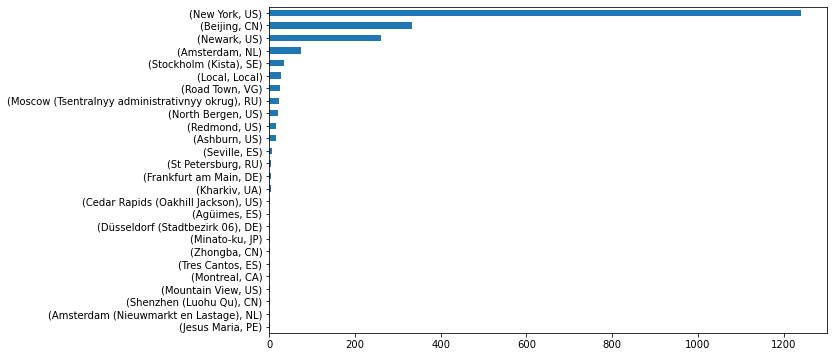

In [37]:

Logs_copy.Location.value_counts(ascending = True).plot(kind = 'barh', figsize = (10,6))

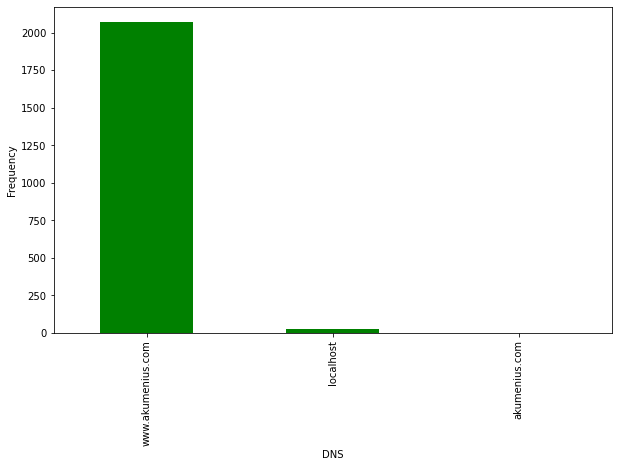

In [38]:
graph = Logs_copy[['DNS', 'Location']].groupby(['DNS']).count().sort_values(by = 'Location',ascending = False)
graph = graph.rename(columns = {'Location' : 'Frequency'})
graph.plot.bar(y = 'Frequency', color = 'g', ylabel = 'Frequency', legend = None, figsize = (10,6))
plt.show()

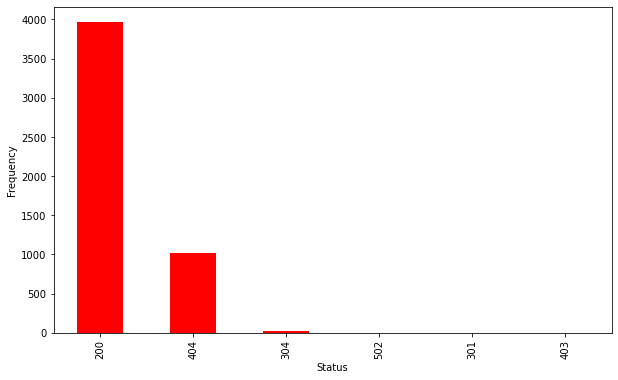

In [39]:
graph = Logs_copy[['Status', 'Time']].groupby(['Status']).count().sort_values(by = 'Time',ascending = False)
graph = graph.rename(columns = {'Time' : 'Frequency'})
graph.plot.bar(y = 'Frequency', color = 'r', ylabel = 'Frequency', legend = None, figsize = (10,6))
plt.show()

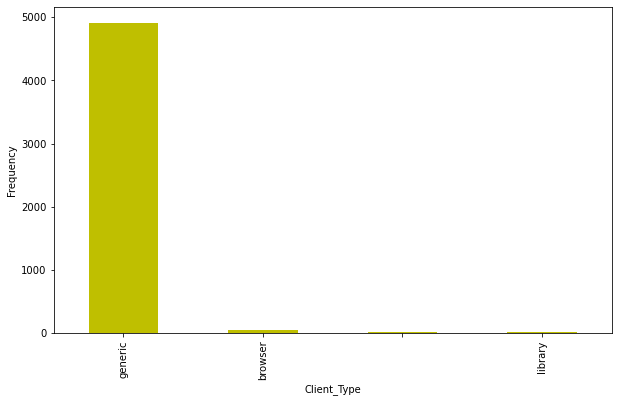

In [40]:
graph = Logs_copy[['Client_Type', 'Time']].groupby(['Client_Type']).count().sort_values(by = 'Time',ascending = False)
graph = graph.rename(columns = {'Time' : 'Frequency'})
graph.plot.bar(y = 'Frequency', color = 'y', ylabel = 'Frequency', legend = None, figsize = (10,6))
plt.show()

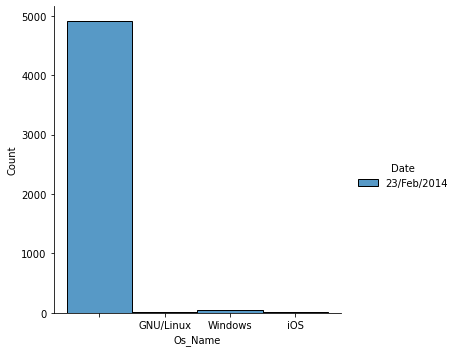

In [41]:
sns.displot(data = Logs_copy, x = "Os_Name", hue = "Date", multiple = "stack")

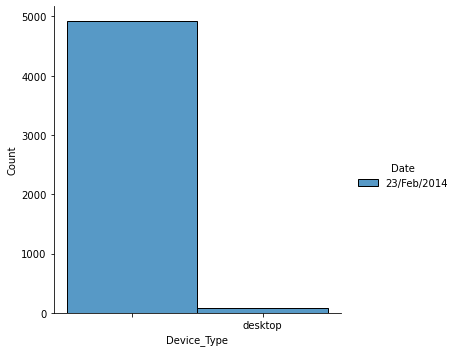

In [42]:
sns.displot(data = Logs_copy, x = "Device_Type", hue = "Date", multiple = "stack")

In [43]:
Logs_export = Logs_copy.copy()

Logs_export.replace('', 'null', inplace = True)

Logs_export.to_csv('../Data/Logs_export.csv', index = False)